In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint  
from math import pi
from qutip import Options, sigmax, sigmaz, sesolve, mesolve, basis, expect, tensor, qeye, destroy, Qobj
from scipy.optimize import curve_fit
from schedule import run, generate_local_adiabatic_pulse, ramp_array, ramp, Schedule, find_eigen
import sympy as sp
from sympy.assumptions.refine import refine_abs, refine
from sympy import Q, Abs, Eq
from copy import deepcopy
from math import factorial, floor
from tqdm import tqdm

d:\anaconda3\envs\qubit-reset\lib\site-packages\qutip\__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


### 1.

In [7]:
g = 50e-3 # GHz
dt = 0.01 # ns
unit = 2 * pi
y0 = -50.0 * g
y1 = +50.0 * g


def dy_dt(y, args):
    scale, g = args['scale'], args['g']
    dy_dt = scale * (1 / g) * (y ** 2 + 4 * g ** 2) ** 1.5
    return dy_dt


def num_generate_local_adiabatic_pulse(amp_init, amp_final, dy_dt, args, dt):
    seq = [amp_init]
    diff = seq[-1] - amp_final
    _y = amp_init
    while diff < 0:
        _y = seq[-1] + dy_dt(_y, args) * dt
        diff = _y - amp_final
        seq.append(_y)
    if abs(seq[-1] - amp_final) >= 1e-2:
        seq[-1] = amp_final
    else:
        pass
    seq = np.array(seq, dtype=float)
    return seq

In [3]:
scale1 = 0.1

args = {'g': g, 'y0': y0, 'yt': y1, 'scale': scale1}
yy1 = num_generate_local_adiabatic_pulse(y0, y1, dy_dt, args=args, dt=dt)
xx1 = np.linspace(0, len(yy1) * dt, len(yy1))

In [4]:
scale2 = 0.2

args = {'g': g, 'y0': y0, 'yt': y1, 'scale': scale2}
yy2 = num_generate_local_adiabatic_pulse(y0, y1, dy_dt, args=args, dt=dt)
xx2 = np.linspace(0, len(yy2) * dt, len(yy2))

In [5]:
scale3 = 0.4

args = {'g': g, 'y0': y0, 'yt': y1, 'scale': scale3}
yy3 = num_generate_local_adiabatic_pulse(y0, y1, dy_dt, args=args, dt=dt)
xx3 = np.linspace(0, len(yy3) * dt, len(yy3))

In [6]:
# linear

duration = xx1[-1]
yy4 = np.linspace(y0, y1, int(np.ceil(duration / dt)))
xx4 = np.linspace(0, len(yy4) * dt, len(yy4))


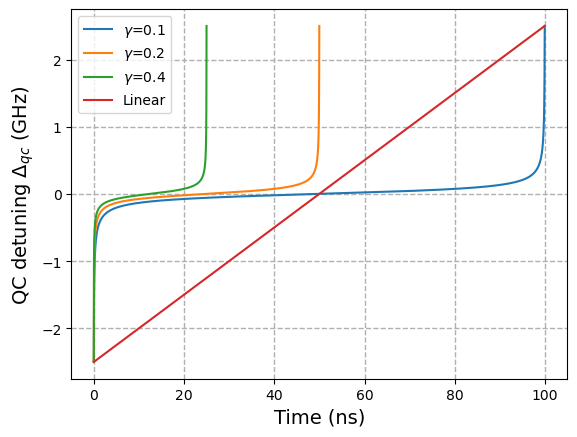

In [7]:
plt.plot(xx1, yy1, label=f'$\gamma$={scale1}')
plt.plot(xx2, yy2, label=f'$\gamma$={scale2}')
plt.plot(xx3, yy3, label=f'$\gamma$={scale3}')
plt.plot(xx4, yy4, label=f'Linear')
plt.grid(linestyle = '--', linewidth = 1.0)

plt.legend()
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel(r'QC detuning $\Delta_{qc}$ (GHz)', fontsize=14)
plt.show()

In [3]:
# Device parameters, all parameters are in GHz or nanoseconds
fq0 = 3000e-3

fc0 = fq0 - y0
fct = fq0 - y1
alphaq = -195.591338e-3 # qubit 1 anharmonicity
alphac = -60e-3  # coupler anharmonicity
detunig_qc0 = fq0 - fc0
fq = 5432e-3
# Levels
qubit_levels = 3
coupler_levels = 3

# Operators
a = tensor(destroy(qubit_levels), qeye(coupler_levels))
c = tensor(qeye(qubit_levels), destroy(coupler_levels))

# Uncoupled Hamiltonian
H0 = fq0 * 2 * pi * a.dag() * a + 0.5 * alphaq * 2 * pi * a.dag() * a.dag() * a * a + fc0 * 2 * pi * c.dag() * c + 0.5 * alphac * 2 * pi * c.dag() * c.dag() * c * c 

# Interaction Hamiltonian
H1 = g * 2 * pi * (a.dag() * c + a * c.dag())

# Coupled Hamiltonian
H2 = H0 + H1

# Perturbation term for tuning up the coupler frequency
Hd = 2 * pi * c.dag() * c

In [4]:
psi10 = tensor(basis(qubit_levels, 1), basis(coupler_levels, 0))
psi01 = tensor(basis(qubit_levels, 0), basis(coupler_levels, 1))
psi20 = tensor(basis(qubit_levels, 2), basis(coupler_levels, 0))
psi02 = tensor(basis(qubit_levels, 0), basis(coupler_levels, 2))
psi11 = tensor(basis(qubit_levels, 1), basis(coupler_levels, 1))

proj10 = psi10 * psi10.dag()
proj01 = psi01 * psi01.dag()
proj20 = psi20 * psi20.dag()
proj02 = psi02 * psi02.dag()
proj11 = psi11 * psi11.dag()

# Eigenenergies and eigenstates
eigenenergies, eigenstates = H2.eigenstates()
psi_init_01, _, _ = find_eigen(psi01, eigenstates, eigenenergies)
psi_init_10, _, _ = find_eigen(psi10, eigenstates, eigenenergies)


In [5]:
H = [H2, [Hd, -yy1+fq0-fc0]]
times = xx1

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals1, overlap1 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop1 = exp_vals1[0]

NameError: name 'yy1' is not defined

In [6]:
H = [H2, [Hd, -yy2+fq0-fc0]]
times = xx2

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals2, overlap2 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop2 = exp_vals1[0]

NameError: name 'yy2' is not defined

In [65]:
H = [H2, [Hd, -yy3+fq0-fc0]]
times = xx3

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals3, overlap3 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop3 = exp_vals1[0]

In [66]:
H = [H2, [Hd, -yy4+fq0-fc0]]
times = xx4

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals4, overlap4 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop4 = exp_vals1[0]

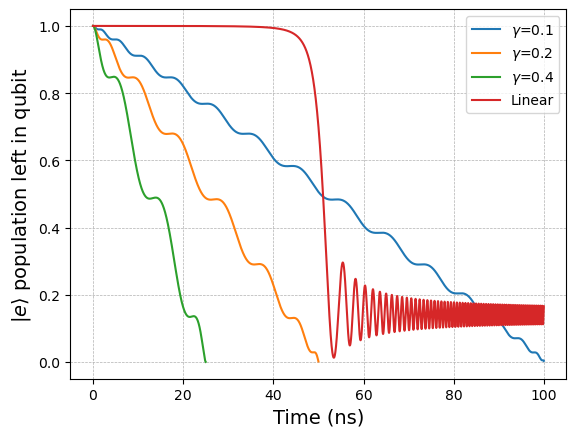

In [68]:
plt.plot(xx1, exp_vals1[0], label=r'$\gamma$' + f'={scale1}')
plt.plot(xx2, exp_vals2[0], label=r'$\gamma$' + f'={scale2}')
plt.plot(xx3, exp_vals3[0], label=r'$\gamma$' + f'={scale3}')
plt.plot(xx4, exp_vals4[0], label=f'Linear')

plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel(r'$|e\rangle$ population left in qubit', fontsize=14)

plt.legend()
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

In [17]:
exp_vals3[0][-1]

0.0002743087564301037

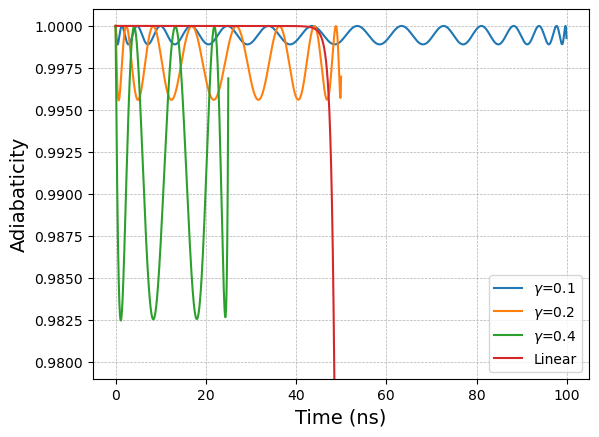

In [70]:
step = 1
plt.plot(xx1[::step], overlap1[::step], label=rf'$\gamma$={scale1}')
plt.plot(xx2[::step], overlap2[::step], label=rf'$\gamma$={scale2}')
plt.plot(xx3[::step], overlap3[::step], label=rf'$\gamma$={scale3}')
plt.plot(xx4[::step], overlap4[::step], label=rf'Linear')

plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel(r'Adiabaticity', fontsize=14)
plt.ylim(0.979, 1.001)
plt.legend()
plt.grid(linestyle = '--', linewidth = 0.5)

plt.show()

2.

In [86]:
g_paras = [0.02, 0.05, 0.20, 0.5]
duration = 100
dt = 0.1


In [87]:

flux1 = generate_local_adiabatic_pulse(g=g_paras[0], T=duration, y0=y0, yt=y1, dt=dt)
flux2 = generate_local_adiabatic_pulse(g=g_paras[1], T=duration, y0=y0, yt=y1, dt=dt)
flux3 = generate_local_adiabatic_pulse(g=g_paras[2], T=duration, y0=y0, yt=y1, dt=dt)
flux4 = generate_local_adiabatic_pulse(g=g_paras[3], T=duration, y0=y0, yt=y1, dt=dt)
# flux5 = generate_local_adiabatic_pulse(g=g_paras[4], T=duration, y0=y0, yt=y1, dt=dt)


times = np.linspace(0, duration, len(flux1))


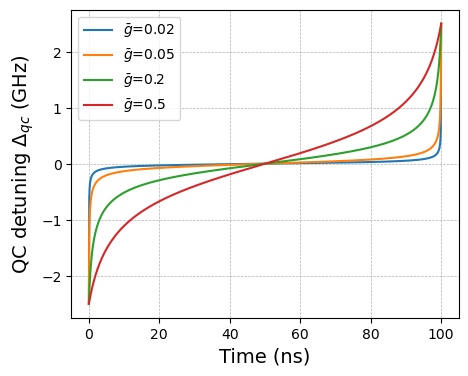

In [103]:
plt.figure(figsize=(5, 4))
plt.plot(times, flux1, label=r'$\bar{g}$' + f'={g_paras[0]}')
plt.plot(times, flux2, label=r'$\bar{g}$' + f'={g_paras[1]}')
plt.plot(times, flux3, label=r'$\bar{g}$' + f'={g_paras[2]}')
plt.plot(times, flux4, label=r'$\bar{g}$' + f'={g_paras[3]}')

plt.grid(linestyle = '--', linewidth = 0.5)

plt.legend()
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel(r'QC detuning $\Delta_{qc}$ (GHz)', fontsize=14)
plt.show()

In [89]:
H = [H2, [Hd, -flux1+fq0-fc0]]

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals1, overlap1 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop1 = exp_vals1[0]

H = [H2, [Hd, -flux2+fq0-fc0]]

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals2, overlap2 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop2 = exp_vals2[0]

H = [H2, [Hd, -flux3+fq0-fc0]]

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals3, overlap3 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop3 = exp_vals3[0]

H = [H2, [Hd, -flux4+fq0-fc0]]

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals4, overlap4 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop4 = exp_vals4[0]

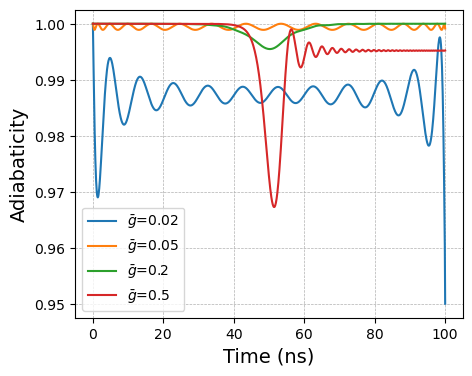

In [104]:
plt.figure(figsize=(5, 4))
plt.plot(times, overlap1, label=r'$\bar{g}$'+f'={g_paras[0]}')
plt.plot(times, overlap2, label=r'$\bar{g}$'+f'={g_paras[1]}')
plt.plot(times, overlap3, label=r'$\bar{g}$'+f'={g_paras[2]}')
plt.plot(times, overlap4, label=r'$\bar{g}$'+f'={g_paras[3]}')

plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel(r'Adiabaticity', fontsize=14)

plt.legend()
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

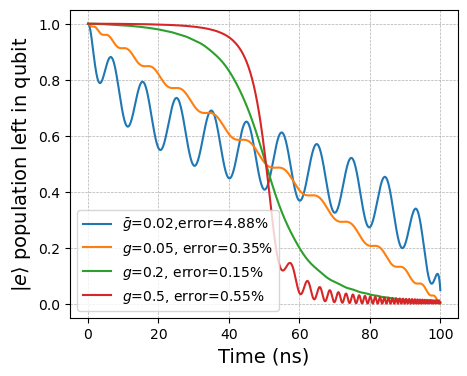

In [130]:
plt.figure(figsize=(5, 4))
plt.plot(times, exp_vals1[0], label=r'$\bar{g}$' + f'={g_paras[0]},' + f'error={round(exp_vals1[0][-1] * 100, 2)}%')
plt.plot(times, exp_vals2[0], label=r'$\bar{g}$' + f'={g_paras[1]},' + f'error={round(exp_vals1[0][-1] * 100, 2)}%')
plt.plot(times, exp_vals3[0], label=r'$\bar{g}$' + f'={g_paras[2]},' + f'error={round(exp_vals1[0][-1] * 100, 2)}%')
plt.plot(times, exp_vals4[0], label=r'$\bar{g}$' + f'={g_paras[3]},' + f'error={round(exp_vals1[0][-1] * 100, 2)}%')

plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel(r'$|e\rangle$ population left in qubit', fontsize=14)

plt.legend()
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

In [49]:
# optimal g, sweep time
g_paras = [0.05, 0.5]
duration_sweep = np.linspace(80, 150, 100)
exp_vs_duration_a = []
adia_vs_duration_a = []

exp_vs_duration_b = []
adia_vs_duration_b = []
expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
dt = 0.2
for T in tqdm(duration_sweep):
    exp_vals_a = []
    flux_a = generate_local_adiabatic_pulse(g=g_paras[0], T=T, y0=y0, yt=y1, dt=dt)
    flux_b = generate_local_adiabatic_pulse(g=g_paras[1], T=T, y0=y0, yt=y1, dt=dt)
    Ha = [H2, [Hd, -flux_a+fq0-fc0]]
    Hb = [H2, [Hd, -flux_b+fq0-fc0]]

    time_a = np.linspace(0, T, len(flux_a))    
    exp_a, overlap_a = run(H0=Ha[0], Ht=Ha[1], times=time_a, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
    exp_vs_duration_a.append(exp_a[0][-1])
    adia_vs_duration_a.append(overlap_a[-1])

    time_b = np.linspace(0, T, len(flux_b))    
    exp_b, overlap_b = run(H0=Hb[0], Ht=Hb[1], times=time_b, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
    exp_vs_duration_b.append(exp_b[0][-1])
    adia_vs_duration_b.append(overlap_b[-1])

100%|██████████| 100/100 [04:50<00:00,  2.91s/it]


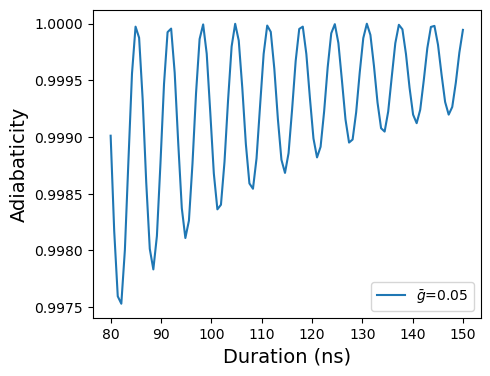

In [52]:
plt.figure(figsize=(5, 4))
plt.plot(duration_sweep, adia_vs_duration_a, label=r'$\bar{g}$'+f'={g_paras[0]}')
plt.xlabel('Duration (ns)', fontsize=14)
plt.ylabel('Adiabaticity', fontsize=14)
# plt.ylim(0.98, 1.002)
plt.legend()
plt.show()

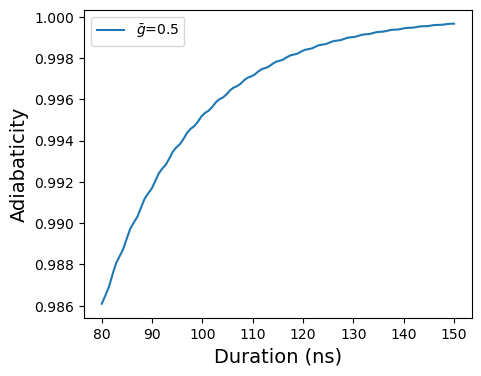

In [53]:
plt.figure(figsize=(5, 4))
plt.plot(duration_sweep, adia_vs_duration_b, label=r'$\bar{g}$'+f'={g_paras[1]}')
plt.xlabel('Duration (ns)', fontsize=14)
plt.ylabel('Adiabaticity', fontsize=14)
# plt.ylim(0.98, 1.002)
plt.legend()
plt.show()

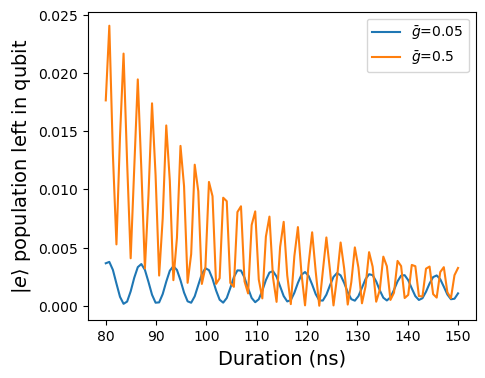

In [54]:
plt.figure(figsize=(5, 4))
plt.plot(duration_sweep, exp_vs_duration_a, label=r'$\bar{g}$'+f'={g_paras[0]}')
plt.plot(duration_sweep, exp_vs_duration_b, label=r'$\bar{g}$'+f'={g_paras[1]}')
plt.xlabel('Duration (ns)', fontsize=14)
plt.ylabel(r'$|e\rangle$ population left in qubit', fontsize=14)
# plt.ylim(0.98, 1.002)
plt.legend()
plt.show()

In [155]:
print(exp_vs_duration_a[-1])
print(exp_vs_duration_b[-1])


0.012915995182039428
0.0016735264178316426


# 3LS spectrum

In [24]:
def ham_3ls(omega1, omega2, g, alpha1, alpha2):
    h_mat = np.array([
    [2 * omega1 + alpha1, g, 0],
    [g, omega1 + omega2, g],
    [0, g, 2 * omega2 + alpha2]
], dtype=complex)
    return h_mat


def ham_tls2(freq_c, freq_q, g):
    h_mat = np.array([
    [freq_q, g],
    [g, freq_c] 
    ], dtype=complex)
    return h_mat

def ham_tls(detuning, g):
    h_mat = np.array([
        [detuning, g],
        [g, -detuning] 
    ], dtype=complex)
    return h_mat

def npad_rot(h, j, k):
    delta_jk = 0.5 * (h[j, j] - h[k, k])
    g_jk = h[j, k]
    theta = np.arctan(g_jk / delta_jk)
    c_jk = np.cos(theta / 2)
    s_jk = np.sin(theta / 2)
    u_jk = np.zeros_like(h, dtype=complex)
    np.fill_diagonal(u_jk, 1. + 0j)
    u_jk[j, j] = c_jk
    u_jk[k, k] = c_jk
    u_jk[j, k] = s_jk
    u_jk[k, j] = -s_jk
    h_pr = u_jk @ h @ u_jk.conj().T
    if h_pr[j, j] > h_pr[k, k]:
        h_pr[:, [j, k]] = h_pr[:, [k, j]]
        h_pr[[j, k], :] = h_pr[[k, j], :]
    return h_pr

def npad_rot_sym(h, j, k):
    delta_jk =  (h[j, j] - h[k, k]) / 2
    g_jk = h[j, k]
    theta = sp.atan(g_jk / delta_jk)
    c_jk = sp.cos(theta / 2)
    s_jk = sp.sin(theta / 2)
    u_jk = sp.eye(h.shape[0], h.shape[1])
    u_jk[j, j] = c_jk
    u_jk[k, k] = c_jk
    u_jk[j, k] = s_jk
    u_jk[k, j] = -s_jk
    h_pr = u_jk @ h @ u_jk.T
    # if h_pr[j, j] > h_pr[k, k]:
    #     h_pr[:, [j, k]] = h_pr[:, [k, j]]
    #     h_pr[[j, k], :] = h_pr[[k, j], :]
    return h_pr

## Symbol NPAD

In [25]:
wq = sp.Symbol('wq', positive=True, real=True, dtype=float)
wc = sp.Symbol('wc', positive=True, real=True, dtype=float)
g = sp.Symbol('g', positive=True, real=True, dtype=float)
a = sp.Symbol('α', positive=False, real=True, dtype=float)
b = sp.Symbol('β', positive=False, real=True, dtype=float)
delta = sp.Symbol('Δ', real=True, dtype=float)
del1 = sp.Symbol('δ1', real=True, positive=True, dtype=float)
gamma = sp.Symbol('γ', real=True, positive=False, dtype=float)
g_val = 50
a_val = -200
del1_alpha = (del1, -a/2)


h0 = sp.Matrix([
[delta,      0,            g],
[0,       -delta,          g],
[g,            g,    del1]])


h0

Matrix([
[Δ,  0,  g],
[0, -Δ,  g],
[g,  g, δ1]])

\begin{align}
H_0 = \begin{pmatrix}
2\omega_q + \alpha & g & 0 \\ g & \omega_q + \omega_c & g \\ 0 & g & 2\omega_c
\end{pmatrix}
\end{align}

\begin{align}
H_0 = \begin{pmatrix}
\Delta & 0 & g \\ 
0 & -\Delta  & g 
\\ g & g & \delta_1
\end{pmatrix}
\end{align}

$$
\Delta = \omega_q - \omega_c + \alpha / 2
$$

\begin{align}
\delta_1 = -\frac{\alpha}{2}
\end{align}

NPAD, first decouple (0, 2)

\begin{align}
shift1 &= \Delta/2 + \delta_1/2 \\
\Delta_1 &= \Delta - shift1 =\frac{\Delta}{2} - \frac{\delta_1}{2}
\end{align}

In [26]:
delta1 = sp.Symbol('Δ1', real=True, dtype=float)
shift1 = (h0[0, 0] + h0[2, 2]) / 2
h0_shift= h0 - shift1 * sp.eye(3)
delta1_delta = (delta1, delta / 2 - del1 / 2)
delta_delta1 = (delta, 2 * delta1 + del1)

h0_input = h0_shift.subs([delta_delta1])

In [27]:
h0_shift

Matrix([
[Δ/2 - δ1/2,             0,           g],
[         0, -3*Δ/2 - δ1/2,           g],
[         g,             g, -Δ/2 + δ1/2]])

In [28]:
h0_input


Matrix([
[Δ1,            0,   g],
[ 0, -3*Δ1 - 2*δ1,   g],
[ g,            g, -Δ1]])

In [29]:
h1 = npad_rot_sym(h0_input, 0, 2)
h1 = sp.simplify(h1)
h1 = sp.simplify(h1)
h1 = sp.refine(h1, sp.Q.negative(delta1))

h1

Matrix([
[-sqrt(g**2 + Δ1**2), g*sin(atan(g/Δ1)/2),                   0],
[g*sin(atan(g/Δ1)/2),        -3*Δ1 - 2*δ1, g*cos(atan(g/Δ1)/2)],
[                  0, g*cos(atan(g/Δ1)/2),  sqrt(g**2 + Δ1**2)]])

$$
s_1 = \sin{(\arctan{(g/\Delta_1)} / 2)}\\
c_1 = \cos{(\arctan{(g/\Delta_1)} / 2)}
$$

$$
shift2 = \frac{\sqrt{\Delta_1^2 + g^2} - 3\Delta_1 - 2\delta_1}{2}

$$

In [30]:
shift2 = (h1[1, 1] + h1[2, 2]) / 2
delta2 = sp.Symbol('Δ2', positive=True, real=True, dtype=float)
s1 = sp.Symbol('s1', real=True, dtype=float)
c1 = sp.Symbol('c1', real=True, dtype=float)

s1_delta1 = (s1, sp.sin(sp.atan(g / delta1) / 2))
c1_delta1 = (c1, sp.cos(sp.atan(g / delta1) / 2))

delta1_s1 = s1_delta1[::-1]
delta1_c1 = c1_delta1[::-1]



delta2_delta1 = (delta2, h1[2, 2] - shift2)
delta1_delta2 = (h1[2, 2] - shift2, delta2)

h1_shift = h1 - shift2 * sp.eye(3)

h1_input = h1_shift.subs([delta1_delta2, delta1_c1, delta1_s1])

In [31]:
h1_shift

Matrix([
[3*Δ1/2 + δ1 - 3*sqrt(g**2 + Δ1**2)/2,                 g*sin(atan(g/Δ1)/2),                                  0],
[                 g*sin(atan(g/Δ1)/2), -3*Δ1/2 - δ1 - sqrt(g**2 + Δ1**2)/2,                g*cos(atan(g/Δ1)/2)],
[                                   0,                 g*cos(atan(g/Δ1)/2), 3*Δ1/2 + δ1 + sqrt(g**2 + Δ1**2)/2]])

In [32]:
h1_input

Matrix([
[3*Δ1/2 + δ1 - 3*sqrt(g**2 + Δ1**2)/2, g*s1,    0],
[                                g*s1,  -Δ2, c1*g],
[                                   0, c1*g,   Δ2]])

In [33]:
h2 = npad_rot_sym(h1_input, 1, 2)
h2 = sp.simplify(h2)
h2 = sp.simplify(h2)
h2 = sp.refine(h2, sp.Q.positive(delta2))

h2

Matrix([
[3*Δ1/2 + δ1 - 3*sqrt(g**2 + Δ1**2)/2, g*s1*cos(atan(c1*g/Δ2)/2), g*s1*sin(atan(c1*g/Δ2)/2)],
[           g*s1*cos(atan(c1*g/Δ2)/2), -sqrt(c1**2*g**2 + Δ2**2),                         0],
[           g*s1*sin(atan(c1*g/Δ2)/2),                         0,  sqrt(c1**2*g**2 + Δ2**2)]])

In [34]:
shift3 = (h2[0, 0] + h2[2, 2]) / 2
h2_shift= h2 - shift3 * sp.eye(3)
delta3 = sp.Symbol('Δ3', real=True, dtype=float)
s2 = sp.Symbol('s2', real=True, dtype=float)
c2 = sp.Symbol('c2', real=True, dtype=float)

s2_delta2 = (s2, sp.sin(sp.atan(c1 * g / delta2) / 2))
c2_delta2 = (c2, sp.cos(sp.atan(c1 * g / delta2) / 2))

delta2_s2 = s2_delta2[::-1]
delta2_c2 = c2_delta2[::-1]



delta3_delta2 = (delta3, h2[2, 2] - shift3)
delta2_delta3 = delta3_delta2[::-1]


h2_input = h2_shift.subs([delta2_delta3, delta2_s2, delta2_c2])


In [35]:
h2_shift

Matrix([
[3*Δ1/4 + δ1/2 - 3*sqrt(g**2 + Δ1**2)/4 - sqrt(c1**2*g**2 + Δ2**2)/2,                                              g*s1*cos(atan(c1*g/Δ2)/2),                                            g*s1*sin(atan(c1*g/Δ2)/2)],
[                                          g*s1*cos(atan(c1*g/Δ2)/2), -3*Δ1/4 - δ1/2 + 3*sqrt(g**2 + Δ1**2)/4 - 3*sqrt(c1**2*g**2 + Δ2**2)/2,                                                                    0],
[                                          g*s1*sin(atan(c1*g/Δ2)/2),                                                                      0, -3*Δ1/4 - δ1/2 + 3*sqrt(g**2 + Δ1**2)/4 + sqrt(c1**2*g**2 + Δ2**2)/2]])

In [36]:
h2_input

Matrix([
[    -Δ3,                                                                c2*g*s1, g*s1*s2],
[c2*g*s1, -3*Δ1/4 - δ1/2 + 3*sqrt(g**2 + Δ1**2)/4 - 3*sqrt(c1**2*g**2 + Δ2**2)/2,       0],
[g*s1*s2,                                                                      0,      Δ3]])

In [37]:
h3 = npad_rot_sym(h2_input, 0, 2)
h3 = sp.simplify(h3)
h3 = sp.simplify(h3)
h3 = sp.refine(h3, sp.Q.positive(delta3))

h3

Matrix([
[-sqrt(g**2*s1**2*s2**2 + Δ3**2),                                        c2*g*s1*cos(atan(g*s1*s2/Δ3)/2),                               0],
[c2*g*s1*cos(atan(g*s1*s2/Δ3)/2), -3*Δ1/4 - δ1/2 + 3*sqrt(g**2 + Δ1**2)/4 - 3*sqrt(c1**2*g**2 + Δ2**2)/2, c2*g*s1*sin(atan(g*s1*s2/Δ3)/2)],
[                              0,                                        c2*g*s1*sin(atan(g*s1*s2/Δ3)/2),  sqrt(g**2*s1**2*s2**2 + Δ3**2)]])

In [38]:
shift4 = (h3[0, 0] + h3[1, 1]) / 2
h3_shift= h3 - shift4 * sp.eye(3)

In [39]:
h3_shift

Matrix([
[3*Δ1/8 + δ1/4 - 3*sqrt(g**2 + Δ1**2)/8 + 3*sqrt(c1**2*g**2 + Δ2**2)/4 - sqrt(g**2*s1**2*s2**2 + Δ3**2)/2,                                                                           c2*g*s1*cos(atan(g*s1*s2/Δ3)/2),                                                                                                          0],
[                                                                         c2*g*s1*cos(atan(g*s1*s2/Δ3)/2), -3*Δ1/8 - δ1/4 + 3*sqrt(g**2 + Δ1**2)/8 - 3*sqrt(c1**2*g**2 + Δ2**2)/4 + sqrt(g**2*s1**2*s2**2 + Δ3**2)/2,                                                                            c2*g*s1*sin(atan(g*s1*s2/Δ3)/2)],
[                                                                                                       0,                                                                           c2*g*s1*sin(atan(g*s1*s2/Δ3)/2), 3*Δ1/8 + δ1/4 - 3*sqrt(g**2 + Δ1**2)/8 + 3*sqrt(c1**2*g**2 + Δ2**2)/4 + 3*sqrt(g**2*s1**2*s2**2 + Δ3**2)/2]])

First NPAD

In [40]:
h1 = npad_rot_sym(h0, 0, 1)

In [41]:
h1 = h1.applyfunc(sp.simplify)

In [42]:
h100 = sp.simplify(h1[0, 0])
h101 = sp.simplify(h1[0, 1])
h111 = sp.simplify(h1[1, 1])
h100


Δ

In [43]:
h1[0, 1] = 0.0
h1[1, 0] = 0.0
h1[1, 1] = h111
h1[0, 0] = h100

h1

Matrix([
[Δ,  0,  g],
[0, -Δ,  g],
[g,  g, δ1]])

In [44]:
h1_diag = h1.diagonal()

In [46]:
g_val = 50e-3
a_val = -200e-3
# expr_sub = {g: g_val, delta: np.linspace(-10 * g_val, 10 * g_val, 100)}
delta_sweep = np.linspace(-10 * g_val, 10 * g_val, 100)

diag_exprs = h1.diagonal()
energies0 = [diag_exprs[0].subs({g: g_val, delta: d}) for d in delta_sweep]
energies1 = [diag_exprs[1].subs({g: g_val, delta: d}) for d in delta_sweep]
energies2 = [diag_exprs[2].subs({g: g_val, delta: d, a: a_val, del1: -a_val/2}) for d in delta_sweep]

for i in range(len(energies0)):
    if energies0[i] > energies1[i]:
        temp = energies1[i]
        energies1[i] = energies0[i]
        energies0[i] = temp

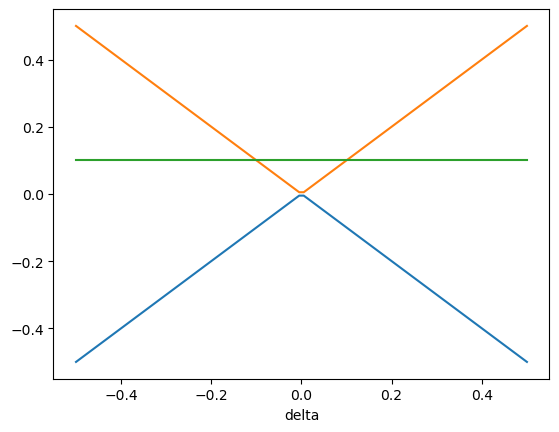

In [47]:
plt.plot(delta_sweep, energies0)
plt.plot(delta_sweep, energies1)
plt.plot(delta_sweep, energies2)

plt.xlabel('delta')
plt.show()

Second NPAD

In [48]:
h1

Matrix([
[Δ,  0,  g],
[0, -Δ,  g],
[g,  g, δ1]])

In [49]:
E1 = sp.Symbol('E1', real=True)
s1 = sp.Symbol('s1', real=True)
c1 = sp.Symbol('c1', real=True)
E2 = sp.Symbol('E2', real=True)

s1_delta_sub = (s1, sp.sin(sp.atan(g/delta)/2))
c1_delta_sub = (c1, sp.cos(sp.atan(g/delta)/2))

delta_s1_sub = (sp.sin(sp.atan(g/delta)/2), s1)
delta_c1_sub = (sp.cos(sp.atan(g/delta)/2), c1)

# Eq(s1, sp.sin(sp.atan(g/delta)/2))
# Eq(c1, sp.cos(sp.atan(g/delta)/2))


h1_sim = sp.Matrix([
[h1[0, 0],      0,           s1 * g],
[0,       h1[1, 1],         c1 * g],
[s1 * g,          c1 * g,    h1[2, 2]]])
h1_sim


Matrix([
[   Δ,    0, g*s1],
[   0,   -Δ, c1*g],
[g*s1, c1*g,   δ1]])

In [50]:
h1_sim.subs([delta_s1_sub, delta_c1_sub])

Matrix([
[   Δ,    0, g*s1],
[   0,   -Δ, c1*g],
[g*s1, c1*g,   δ1]])

\begin{align}
s_1 = \sin\left(\frac{\arctan(g/\Delta)}{2}\right) \\
c_1 = \cos\left(\frac{\arctan(g/\Delta)}{2}\right)
\end{align}

In [51]:
# shift
# E1 = sp.Symbol('E1', real=True)
# s01 = sp.Symbol('s01', real=True)
# c01 = sp.Symbol('c01', real=True)
# E2 = sp.Symbol('E2', real=True)
# delta2 = sp.Symbol('Δ2')

# h1_input = sp.Matrix([
# [3 * E1/2 - E2 / 2,      0,           s01 * g],
# [0,       delta2,         c01 * g],
# [s01 * g,          c01 * g,    -delta2]])
# h1_input


Delta < 0

In [52]:
h1_sim

Matrix([
[   Δ,    0, g*s1],
[   0,   -Δ, c1*g],
[g*s1, c1*g,   δ1]])

$$
\Delta <0
$$

$\Delta_2$:

\begin{equation}
shift = \frac{\alpha-3\Delta-\sqrt{\Delta^2+g^2}}{2}
\end{equation}

\begin{align}
\Delta_2 &= -\sqrt{\Delta^2 + g ^ 2} - \frac{\alpha-3\Delta-\sqrt{\Delta^2+g^2}}{2} \\
&= \frac{1}{2}(3\Delta - \sqrt{\Delta^2 + g^2} - \alpha)
\end{align}

\begin{equation}
\delta_2 = \sqrt{\Delta^2 + g^2} - shift
\end{equation}


\begin{equation}
shift = \frac{\alpha-3\Delta-\sqrt{\Delta^2+g^2}}{2}
\end{equation}

$H_1$:
\begin{equation}
H_1 = \begin{pmatrix}
\Delta_2 && 0 && g s_{1} \\
0 && \delta_2 && c_{1} g \\
gs_{1} && c_{1}g && -\Delta_2\\
\end{pmatrix}
\end{equation}

In [53]:
delta2 = sp.Symbol('Δ2', real=True)
del2 = sp.Symbol('δ2', real=True)
shift2 = sp.eye(3) * (a - 3 * delta - sp.sqrt(delta ** 2 + g ** 2)) / 2
h1_delta_neg_shifted = h1_sim - shift2
# Eq(delta2, (3 * delta - sp.sqrt(delta**2 + g**2) - a)/2)
# Eq(del2, sp.sqrt(delta**2 + g**2))
delta2_sub = ((3 * delta - sp.sqrt(delta ** 2 + g ** 2) - a) / 2, delta2)
del2_sub = ((3 * sp.sqrt(delta ** 2 + g ** 2) + 3 * delta - a) / 2, del2)
del2_delta_sub = (del2, (3 * sp.sqrt(delta ** 2 + g ** 2) + 3 * delta - a) / 2)
delta2_delta_sub = (delta2, (3 * delta - sp.sqrt(delta ** 2 + g ** 2) - a) / 2)
h1_input = h1_delta_neg_shifted.subs([delta2_sub, del2_sub])

In [54]:
h1_delta_neg = h1_sim.applyfunc(lambda elem: refine(elem, Q.negative(delta)))
h1_delta_neg

Matrix([
[   Δ,    0, g*s1],
[   0,   -Δ, c1*g],
[g*s1, c1*g,   δ1]])

In [55]:
h1_delta_neg_shifted = h1_delta_neg - shift2
h1_delta_neg_shifted

Matrix([
[5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                               0,                                   g*s1],
[                                0, Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                                   c1*g],
[                             g*s1,                            c1*g, 3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2]])

In [56]:
h1_delta_neg_input = h1_delta_neg_shifted.subs([delta2_sub, del2_sub])
h1_delta_neg_input

Matrix([
[5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                               0,                                   g*s1],
[                                0, Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                                   c1*g],
[                             g*s1,                            c1*g, 3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2]])

In [57]:
h2_delta_neg = npad_rot_sym(h1_delta_neg_input, 0, 2)
h2_delta_neg

Matrix([
[ (g*s1*sin(atan(g*s1/(Δ/2 - δ1/2))/2) + (5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*s1/(Δ/2 - δ1/2))/2))*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (g*s1*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*s1/(Δ/2 - δ1/2))/2))*sin(atan(g*s1/(Δ/2 - δ1/2))/2), c1*g*sin(atan(g*s1/(Δ/2 - δ1/2))/2), -(g*s1*sin(atan(g*s1/(Δ/2 - δ1/2))/2) + (5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*s1/(Δ/2 - δ1/2))/2))*sin(atan(g*s1/(Δ/2 - δ1/2))/2) + (g*s1*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*s1/(Δ/2 - δ1/2))/2))*cos(atan(g*s1/(Δ/2 - δ1/2))/2)],
[                                                                                                                                                                                                                                                        c1*g*sin(atan(g*s1/(Δ/2 - δ1/2))/2),     Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                                                            

In [58]:
h2_delta_neg = h2_delta_neg.applyfunc(lambda elem: sp.simplify(elem))
h2_delta_neg = h2_delta_neg.applyfunc(lambda elem: sp.simplify(elem))
h2_delta_neg

Matrix([
[(g*s1*sin(atan(g*s1/(Δ/2 - δ1/2))/2) + (5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*s1/(Δ/2 - δ1/2))/2))*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (g*s1*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*s1/(Δ/2 - δ1/2))/2))*sin(atan(g*s1/(Δ/2 - δ1/2))/2), c1*g*sin(atan(2*g*s1/(Δ - δ1))/2),                                                                                                                                                                                                                                                                                           0],
[                                                                                                                                                                                                                                                         c1*g*sin(atan(2*g*s1/(Δ - δ1))/2),   Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                                                                  

In [59]:
energy0_delta_neg_expr = sp.simplify(refine(h2_delta_neg[2, 2], Q.positive(delta2)))
energy0_delta_neg_expr = energy0_delta_neg_expr.subs([s1_delta_sub, delta2_delta_sub])
energy0_delta_neg_expr

-(g*sin(atan(g/Δ)/2)*sin(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2) - (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2))*cos(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2) - (g*sin(atan(g/Δ)/2)*cos(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2) - (5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2))*sin(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2)

In [60]:
energy1_delta_neg_expr = sp.simplify(refine(h2_delta_neg[0, 0], Q.positive(delta2)))
energy1_delta_neg_expr = energy1_delta_neg_expr.subs([s1_delta_sub, delta2_delta_sub])
energy1_delta_neg_expr

(g*sin(atan(g/Δ)/2)*sin(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2) + (5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2))*cos(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2) + (g*sin(atan(g/Δ)/2)*cos(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2) + (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2))*sin(atan(g*sin(atan(g/Δ)/2)/(Δ/2 - δ1/2))/2)

In [61]:
energy2_delta_neg_expr = sp.simplify(refine(h2_delta_neg[1, 1], Q.positive(delta2)))
energy2_delta_neg_expr = energy2_delta_neg_expr.subs([del2_delta_sub])
energy2_delta_neg_expr

Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2

In [62]:
delta_sweep = np.linspace(-10 * g_val, 10 * g_val, 100)

energies0_delta_neg_sym = [energy0_delta_neg_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies1_delta_neg_sym = [energy1_delta_neg_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies2_delta_neg_sym = [energy2_delta_neg_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]


# for i in range(len(energies0)):
#     if energies0[i] > energies1[i]:
#         temp = energies1[i]
#         energies1[i] = energies0[i]
#         energies0[i] = temp
# plt.plot(delta_sweep, energies0_delta_neg_sym)
# plt.plot(delta_sweep, energies1_delta_neg_sym)
# plt.plot(delta_sweep, energies2_delta_neg_sym)


plt.show()

$$
\Delta > 0
$$

In [63]:
h1_delta_pos = h1_sim.applyfunc(lambda elem: refine(elem, Q.positive(delta)))
h1_delta_pos

Matrix([
[   Δ,    0, g*s1],
[   0,   -Δ, c1*g],
[g*s1, c1*g,   δ1]])

In [64]:
h1_delta_pos_shifted = h1_delta_pos - shift2
h1_delta_pos_shifted

Matrix([
[5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                               0,                                   g*s1],
[                                0, Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                                   c1*g],
[                             g*s1,                            c1*g, 3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2]])

In [65]:
h1_delta_neg_shifted

Matrix([
[5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                               0,                                   g*s1],
[                                0, Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                                   c1*g],
[                             g*s1,                            c1*g, 3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2]])

In [66]:
h1_delta_pos_input = h1_delta_pos_shifted.subs([delta2_sub, del2_sub])
h1_delta_pos_input

Matrix([
[5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                               0,                                   g*s1],
[                                0, Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                                   c1*g],
[                             g*s1,                            c1*g, 3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2]])

In [67]:
h2_delta_pos = npad_rot_sym(h1_delta_pos_input, 1, 2)
h2_delta_pos

Matrix([
[   5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                                                                                                                                                                                                                                                            g*s1*sin(atan(c1*g/(-Δ/2 - δ1/2))/2),                                                                                                                                                                                                                                                            g*s1*cos(atan(c1*g/(-Δ/2 - δ1/2))/2)],
[g*s1*sin(atan(c1*g/(-Δ/2 - δ1/2))/2),  (c1*g*sin(atan(c1*g/(-Δ/2 - δ1/2))/2) + (Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(c1*g/(-Δ/2 - δ1/2))/2))*cos(atan(c1*g/(-Δ/2 - δ1/2))/2) + (c1*g*cos(atan(c1*g/(-Δ/2 - δ1/2))/2) + (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(c1*g/(-Δ/2 - δ1/2))/2))*sin(atan(c1*g/(-Δ/2 - δ1/2))/2), -(c1*g*sin(atan(c1*g/(-Δ/2 - δ1/2))/2) + (Δ/2

In [68]:
sp.simplify(h2_delta_pos[1, 2])
h2_delta_pos = h2_delta_pos.applyfunc(lambda elem: sp.simplify(elem))
h2_delta_pos = h2_delta_pos.applyfunc(lambda elem: sp.simplify(elem))
h2_delta_pos

Matrix([
[ 5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                                                                                                                                                                                                                                                        -g*s1*sin(atan(2*c1*g/(Δ + δ1))/2),                                                                                                                                                                                                                                                        g*s1*cos(atan(2*c1*g/(Δ + δ1))/2)],
[-g*s1*sin(atan(2*c1*g/(Δ + δ1))/2), -(c1*g*sin(atan(c1*g/(Δ/2 + δ1/2))/2) - (Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(c1*g/(Δ/2 + δ1/2))/2))*cos(atan(c1*g/(Δ/2 + δ1/2))/2) - (c1*g*cos(atan(c1*g/(Δ/2 + δ1/2))/2) - (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(c1*g/(Δ/2 + δ1/2))/2))*sin(atan(c1*g/(Δ/2 + δ1/2))/2),                                                                     

In [69]:
energy0_expr = sp.simplify(refine(h2_delta_pos[2, 2], Q.positive(delta2)))
energy0_expr = energy0_expr.subs([c1_delta_sub, delta2_delta_sub])
energy0_expr

(g*sin(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2)*cos(atan(g/Δ)/2) + (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2))*cos(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2) + (g*cos(atan(g/Δ)/2)*cos(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2) + (Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2))*sin(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2)

In [70]:
energy1_expr = sp.simplify(refine(h2_delta_pos[1, 1], Q.positive(delta2)))
energy1_expr = energy1_expr.subs([c1_delta_sub, delta2_delta_sub])
energy1_expr

-(g*sin(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2)*cos(atan(g/Δ)/2) - (Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2))*cos(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2) - (g*cos(atan(g/Δ)/2)*cos(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2) - (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2))*sin(atan(g*cos(atan(g/Δ)/2)/(Δ/2 + δ1/2))/2)

In [71]:
energy2_expr = sp.simplify(refine(h2_delta_pos[0, 0], Q.positive(delta2)))
energy2_expr = energy2_expr.subs([del2_delta_sub])
energy2_expr

5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2

In [72]:
delta_sweep = np.linspace(-10 * g_val, 10 * g_val, 100)

energies0_sym = [energy0_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies1_sym = [energy1_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies2_sym = [energy2_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]


# plt.plot(delta_sweep, energies0_sym)
# plt.plot(delta_sweep, energies1_sym)
# plt.plot(delta_sweep, energies2_sym)



plt.show()

Third NPAD

### $\Delta < 0$ and $\Delta_2<0$

In [73]:
h2_delta_neg

Matrix([
[(g*s1*sin(atan(g*s1/(Δ/2 - δ1/2))/2) + (5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*s1/(Δ/2 - δ1/2))/2))*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (g*s1*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*s1/(Δ/2 - δ1/2))/2))*sin(atan(g*s1/(Δ/2 - δ1/2))/2), c1*g*sin(atan(2*g*s1/(Δ - δ1))/2),                                                                                                                                                                                                                                                                                           0],
[                                                                                                                                                                                                                                                         c1*g*sin(atan(2*g*s1/(Δ - δ1))/2),   Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                                                                  

In [74]:
h2_delta_neg_delta2_neg = h2_delta_neg.applyfunc(lambda elem: refine(elem, Q.negative(delta2)))
h2_delta_neg_delta2_neg

Matrix([
[(g*s1*sin(atan(g*s1/(Δ/2 - δ1/2))/2) + (5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*s1/(Δ/2 - δ1/2))/2))*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (g*s1*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*s1/(Δ/2 - δ1/2))/2))*sin(atan(g*s1/(Δ/2 - δ1/2))/2), c1*g*sin(atan(2*g*s1/(Δ - δ1))/2),                                                                                                                                                                                                                                                                                           0],
[                                                                                                                                                                                                                                                         c1*g*sin(atan(2*g*s1/(Δ - δ1))/2),   Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2,                                                                  

\begin{align}
&shift3 = \frac{\delta_2 + \sqrt{\Delta_2^2 + g^2s_1^2}}{2} \\
&\Delta_3 = \delta_2 - shift3 \\
&s_2 = \sin\left({\frac{\arctan{(gs_1/\Delta_2)}}{2}}\right) \\
&c_2 = \cos\left({\frac{\arctan{(gs_1/\Delta_2)}}{2}}\right)
\end{align}

$$
\delta_3 = - \sqrt{\Delta_2^2 + g^2s_1^2} - shift3
$$

In [75]:
s2 = sp.Symbol('s2', real=True)
c2 = sp.Symbol('c2', real=True)
delta3 = sp.Symbol('Δ3', real=True)
del3 = sp.Symbol('δ3', real=True)
s2_delta2_sub = (s2, sp.sin(sp.atan(g * s1 / delta2) / 2))
c2_delta2_sub = (c2, sp.cos(sp.atan(g * s1 / delta2) / 2))

s2_delta2_sub_re = (sp.sin(sp.atan(g * s1 / delta2) / 2), s2)
c2_delta2_sub_re = (sp.cos(sp.atan(g * s1 / delta2) / 2), c2)

shift3 = (del2 + sp.sqrt(delta2**2 + g ** 2 * s1 ** 2)) / 2

delta3_delta2_sub = (delta3, del2 - shift3)
delta3_delta2_sub_re = (del2 - shift3, delta3)
del3_delta2_sub = (del3, - sp.sqrt(delta2**2 + g**2*s1**2) - shift3)
del3_delta2_sub_re = (- sp.sqrt(delta2**2 + g**2*s1**2) - shift3, del3)


In [76]:
h2_delta_neg_delta2_neg_shift = h2_delta_neg_delta2_neg - sp.eye(3) * shift3
h2_delta_neg_delta2_neg_shift

Matrix([
[-δ2/2 - sqrt(g**2*s1**2 + Δ2**2)/2 + (g*s1*sin(atan(g*s1/(Δ/2 - δ1/2))/2) + (5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*s1/(Δ/2 - δ1/2))/2))*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (g*s1*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*s1/(Δ/2 - δ1/2))/2))*sin(atan(g*s1/(Δ/2 - δ1/2))/2),                                   c1*g*sin(atan(2*g*s1/(Δ - δ1))/2),                                                                                                                                                                                                                                                                                                                               0],
[                                                                                                                                                                                                                                                                                     

In [77]:
h2_delta_neg_delta2_neg_shift_input = h2_delta_neg_delta2_neg_shift.subs([c2_delta2_sub_re, s2_delta2_sub_re, delta3_delta2_sub_re])
h2_delta_neg_delta2_neg_shift_input 

Matrix([
[-δ2/2 - sqrt(g**2*s1**2 + Δ2**2)/2 + (g*s1*sin(atan(g*s1/(Δ/2 - δ1/2))/2) + (5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*s1/(Δ/2 - δ1/2))/2))*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (g*s1*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*s1/(Δ/2 - δ1/2))/2))*sin(atan(g*s1/(Δ/2 - δ1/2))/2),                                   c1*g*sin(atan(2*g*s1/(Δ - δ1))/2),                                                                                                                                                                                                                                                                                                                               0],
[                                                                                                                                                                                                                                                                                     

In [78]:
h3_delta_neg_delta2_neg = npad_rot_sym(h2_delta_neg_delta2_neg_shift_input , 1, 2)
h3_delta_neg_delta2_neg

Matrix([
[                                                                                     -δ2/2 - sqrt(g**2*s1**2 + Δ2**2)/2 + (g*s1*sin(atan(g*s1/(Δ/2 - δ1/2))/2) + (5*Δ/2 - α/2 + sqrt(g**2 + Δ**2)/2)*cos(atan(g*s1/(Δ/2 - δ1/2))/2))*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (g*s1*cos(atan(g*s1/(Δ/2 - δ1/2))/2) + (3*Δ/2 - α/2 + δ1 + sqrt(g**2 + Δ**2)/2)*sin(atan(g*s1/(Δ/2 - δ1/2))/2))*sin(atan(g*s1/(Δ/2 - δ1/2))/2),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [79]:
h3_delta_neg_delta2_neg = h3_delta_neg_delta2_neg.applyfunc(lambda elem: sp.simplify(elem))
h3_delta_neg_delta2_neg = h3_delta_neg_delta2_neg.applyfunc(lambda elem: sp.simplify(elem))
h3_delta_neg_delta2_neg

KeyboardInterrupt: 

In [89]:
energy0_step3_expr = sp.simplify(refine(h3_delta_neg_delta2_neg[0, 0], Q.negative(delta2)))
energy0_step3_expr = energy0_step3_expr.subs([s1_delta_sub, delta2_delta_sub, del2_delta_sub])
energy0_step3_expr


NameError: name 'h3_delta_neg_delta2_neg' is not defined

In [65]:
energy1_step3_expr = sp.simplify(refine(h3_delta_neg_delta2_neg[1, 1], Q.negative(delta3)))
energy1_step3_expr = energy1_step3_expr.subs([c1_delta_sub, c2_delta2_sub, s1_delta_sub, delta2_delta_sub, del2_delta_sub, delta3_delta2_sub])
energy1_step3_expr = energy1_step3_expr.subs([s1_delta_sub, delta2_delta_sub, del2_delta_sub])

energy1_step3_expr

-sqrt(g**2*cos(atan(g/Δ)/2)**2*cos(atan(g*sin(atan(g/Δ)/2)/(3*Δ/2 - α/2 - sqrt(g**2 + Δ**2)/2))/2)**2 + (3*Δ/4 - α/4 + 3*sqrt(g**2 + Δ**2)/4 - sqrt(g**2*sin(atan(g/Δ)/2)**2 + (3*Δ/2 - α/2 - sqrt(g**2 + Δ**2)/2)**2)/2)**2)

In [66]:
# energy1_step3_expr = sp.simplify(refine(h3_delta_neg_delta2_neg[0, 0], Q.negative(delta2)))
# energy1_step3_expr = energy0_step3_expr.subs([s1_delta_sub, delta2_delta_sub, del2_delta_sub])
# energy1_step3_expr

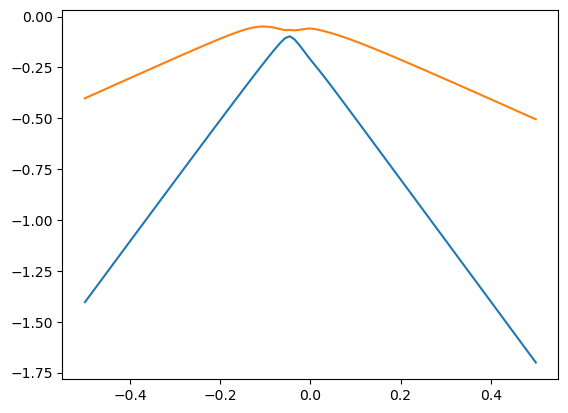

In [67]:

energies0_step3_sym = [energy0_step3_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies1_step3_sym = [energy1_step3_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
# energies2_step3_sym = [energy2_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]


plt.plot(delta_sweep, energies0_step3_sym)
plt.plot(delta_sweep, energies1_step3_sym)
# plt.plot(delta_sweep, energies2_sym)



plt.show()

In [68]:
tls_shift = (energy0_step3_expr + energy1_step3_expr) / 2
energy0_tls_sym = energy0_step3_expr - tls_shift
energy1_tls_sym = energy1_step3_expr - tls_shift


In [374]:
energies0_tls_array = [energy0_tls_sym.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies1_tls_array = [energy1_tls_sym.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]


plt.plot(delta_sweep, energies0_tls_array)
plt.plot(delta_sweep, energies1_tls_array)

plt.show()

NameError: name 'energy0_tls_sym' is not defined

## Numerical NPAD validation

In [153]:
g_val = 50e-3
a_val = -100e-3
# delta_qc_sweep = np.linspace(-20 * g_val, 20 * g_val, 100)
delta1_sweep = np.linspace(-2 * g_val, 2 * g_val, 100)

In [154]:
def ham_3ls_delta1(delta1, g, a_val):
    h_mat = np.array([
    [delta1, 0, g],
    [0, -delta1, g], 
    [g, g, -0.5 * a_val]
    ], dtype=complex)
    return h_mat

# def npad_num(h_list):
#     energies_list = []
#     for h in h_list:
#         energies = Qobj(h).diag()
#         energies_list.append(energies)
#     energies_mat = np.array(energies_list).T
#     return energies_mat


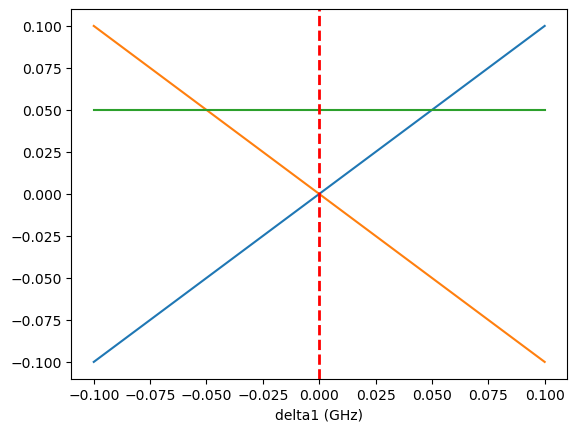

In [155]:
energies_3ls_step0_list = []
h0_list = [ham_3ls_delta1(d1, g_val, a_val) for d1 in delta1_sweep]

for h in h0_list:
    energies = Qobj(h).diag()
    energies_3ls_step0_list.append(energies)
energies_3ls_step0_mat = np.array(energies_3ls_step0_list).T

plt.plot(delta1_sweep, energies_3ls_step0_mat[0])
plt.plot(delta1_sweep, energies_3ls_step0_mat[1])
plt.plot(delta1_sweep, energies_3ls_step0_mat[2])
plt.axvline(x=0., color='r', linestyle='--', linewidth=2)

plt.xlabel('delta1 (GHz)')
plt.show()

[]

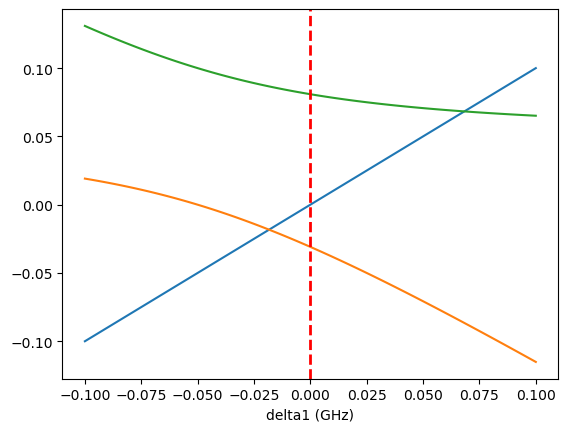

In [156]:
energies_3ls_step1_list = []

h1_list = [npad_rot(h0, 1, 2) for h0 in h0_list]

for h in h1_list:
    energies = Qobj(h).diag()
    energies_3ls_step1_list.append(energies)
energies_3ls_step1_mat = np.array(energies_3ls_step1_list).T

plt.plot(delta1_sweep, energies_3ls_step1_mat[0])
plt.plot(delta1_sweep, energies_3ls_step1_mat[1])
plt.plot(delta1_sweep, energies_3ls_step1_mat[2])

plt.axvline(x=0., color='r', linestyle='--', linewidth=2)

plt.xlabel('delta1 (GHz)')
plt.plot()

In [157]:
h2_list = []
for h1 in h1_list:
    # shift = 0.5 * (h1[0, 0] + h1[2, 2])
    shift = 0.
    h2_list.append(npad_rot(h1 - shift * np.eye(3), 0, 2))

[]

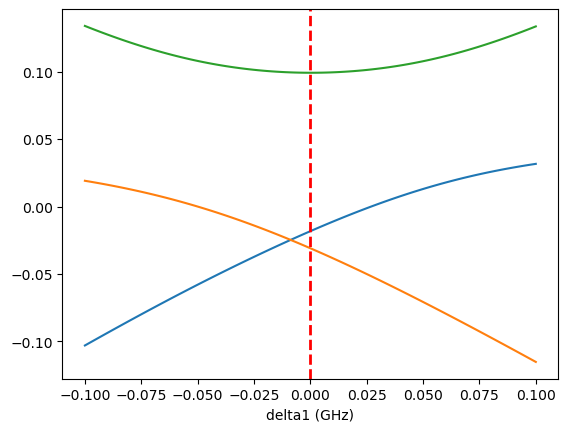

In [158]:
step = 2
energies_3ls_step2_list = []

for h in h2_list:
    energies = Qobj(h).diag()
    energies_3ls_step2_list.append(energies)
energies_3ls_step2_mat = np.array(energies_3ls_step2_list).T

x_sweep = delta1_sweep

plt.plot(x_sweep, energies_3ls_step2_mat[0])
plt.plot(x_sweep, energies_3ls_step2_mat[1])
plt.plot(x_sweep, energies_3ls_step2_mat[2])


# plt.plot(delta_sweep[::step], energies0_sym[::step], '.-')
# plt.plot(delta_sweep[::step], energies1_sym[::step], '.-')
# plt.plot(delta_sweep[::step], energies2_sym[::step], '.-')

# plt.plot(x_sweep[::step], energies0_delta_neg_sym[::step], '.-')
# plt.plot(delta_sweep[::step], energies1_delta_neg_sym[::step], '.-')
# plt.plot(delta_sweep[::step], energies2_delta_neg_sym[::step], '.-')

plt.axvline(x=0., color='r', linestyle='--', linewidth=2)

plt.xlabel('delta1 (GHz)')
plt.plot()

In [159]:
h3_list = []
for h2 in h2_list:
    # shift = 0.5 * (h2[1, 1] + h2[2, 2])
    shift = 0.
    h3_list.append(npad_rot(h2 - shift * np.eye(3), 1, 2))

In [160]:
eigen_3ls_energies = []
for d1 in delta1_sweep:
    _h = ham_3ls_delta1(d1, g_val, a_val)
    h_qobj = Qobj(_h)
    energies = h_qobj.eigenenergies()
    eigen_3ls_energies.append(energies)
eigen_3ls_energies_mat = np.array(eigen_3ls_energies).T

eigen_shift = 0.5 * (eigen_3ls_energies_mat[0] +  eigen_3ls_energies_mat[1])
eigen_val0 = eigen_3ls_energies_mat[0] - eigen_shift
eigen_val1 = eigen_3ls_energies_mat[1] - eigen_shift

[]

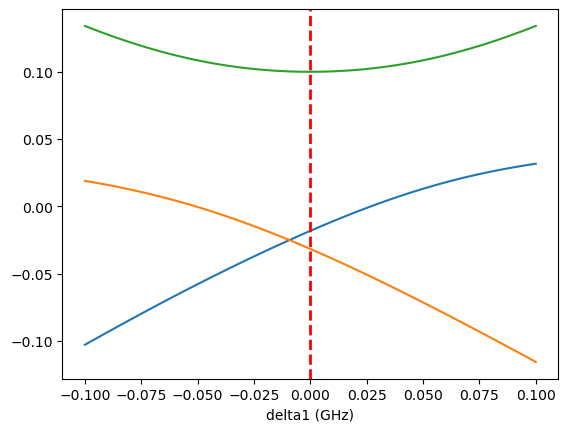

In [161]:
step = 2
energies_3ls_step3_list = []


for h in h3_list:
    energies = Qobj(h).diag()
    energies_3ls_step3_list.append(energies)
energies_3ls_step3_mat = np.array(energies_3ls_step3_list).T


x_sweep = delta1_sweep


plt.plot(x_sweep, energies_3ls_step3_mat[0])
plt.plot(x_sweep, energies_3ls_step3_mat[1])
plt.plot(x_sweep, energies_3ls_step3_mat[2])


# plt.plot(delta1_sweep[::step], energies0_step3_sym[::step],'.')
# plt.plot(delta1_sweep[::step], energies1_step3_sym[::step], '.')

plt.axvline(x=0., color='r', linestyle='--', linewidth=2)

plt.xlabel('delta1 (GHz)')
plt.plot()

In [162]:
h4_list = []
for h3 in h3_list:
    # shift = 0.5 * (h2[0, 0] + h2[2, 2])
    shift = 0.
    h4_list.append(npad_rot(h3 - shift * np.eye(3), 0, 1))

[]

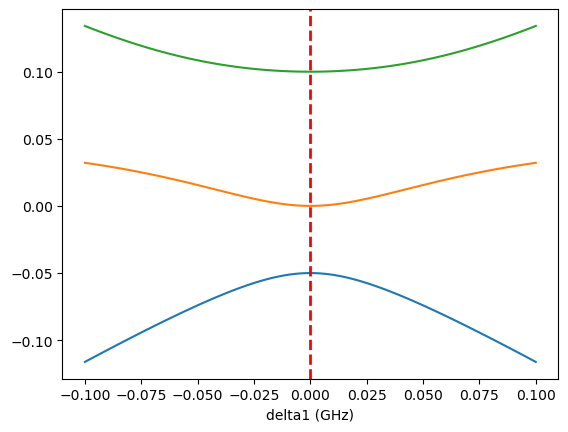

In [163]:
step = 2
energies_3ls_step4_list = []

for h in h4_list:
    energies = Qobj(h).diag()
    energies_3ls_step4_list.append(energies)
energies_3ls_step4_mat = np.array(energies_3ls_step4_list).T

x_sweep = delta1_sweep


plt.plot(x_sweep, energies_3ls_step4_mat[0])
plt.plot(x_sweep, energies_3ls_step4_mat[1])
plt.plot(x_sweep, energies_3ls_step4_mat[2])


# plt.plot(delta_sweep[::step], energies0_sym[::step], '.-')
# plt.plot(delta_sweep[::step], energies1_sym[::step], '.-')
# plt.plot(delta_sweep[::step], energies2_sym[::step], '.-')

# plt.plot(x_sweep[::step], energies0_delta_neg_sym[::step], '.-')
# plt.plot(delta_sweep[::step], energies1_delta_neg_sym[::step], '.-')
# plt.plot(delta_sweep[::step], energies2_delta_neg_sym[::step], '.-')

plt.axvline(x=0., color='r', linestyle='--', linewidth=2)

plt.xlabel('delta1 (GHz)')
plt.plot()

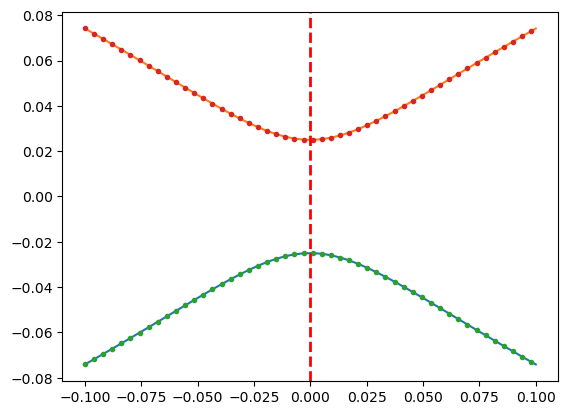

In [164]:
shift01 = 0.5 * (energies_3ls_step4_mat[0] + energies_3ls_step4_mat[1])
is_shift = 1.
eigen_step = 2

x_sweep = delta1_sweep

plt.plot(x_sweep, energies_3ls_step4_mat[0] - is_shift * shift01)
plt.plot(x_sweep, energies_3ls_step4_mat[1] - is_shift * shift01)

plt.plot(delta1_sweep[::eigen_step], eigen_val0[::eigen_step], '.', label='eigen')
plt.plot(delta1_sweep[::eigen_step], eigen_val1[::eigen_step], '.')

# plt.plot(x_sweep, energies0_tls_array, '.')
# plt.plot(x_sweep, energies1_tls_array, '.')
plt.axvline(x=0., color='r', linestyle='--', linewidth=2)

plt.show()



In [165]:
def fit_tls_diff_simple(x, g, scale):
    return 2 * scale * np.sqrt(x ** 2 + g ** 2)

def fit_tls(x, g, scale):
    return scale * np.sqrt(x ** 2 + g ** 2)

0.036310635853077866
0.7116792791402982


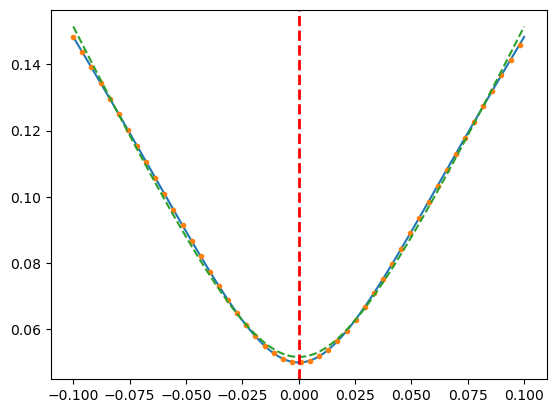

In [166]:
diff2 = energies_3ls_step4_mat[1] - energies_3ls_step4_mat[0]
diff_eigen = eigen_val1 - eigen_val0

para_tls_eigen, pcov = curve_fit(fit_tls_diff_simple, delta1_sweep, diff2)
g_tls2 = para_tls_eigen[0]
scale_tls2 = para_tls_eigen[1]
plt.plot(delta1_sweep, diff2)
plt.plot(delta1_sweep[::eigen_step], diff_eigen[::eigen_step], '.')
plt.plot(delta1_sweep, fit_tls_diff_simple(delta1_sweep, g_tls2, scale_tls2), '--')


plt.axvline(x=0., color='r', linestyle='--', linewidth=2)

print(g_tls2)
print(scale_tls2)

plt.show()

## Numerical NPAD

[]

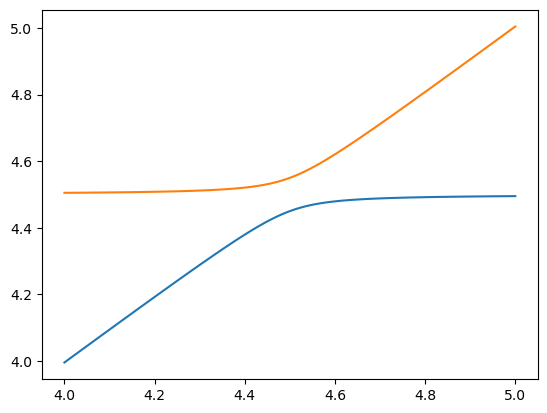

In [167]:
g = 50e-3
freq_q = 4.5
freq_c_sweep = np.linspace(5.0, 4.0, 100)
energies_list_tls = []
for f_c in freq_c_sweep:
    h = ham_tls2(f_c, freq_q, g)
    h_npad = npad_rot(h, 0, 1)
    energies = Qobj(h_npad).diag()
    energies_list_tls.append(energies)
energies_mat_tls = np.array(energies_list_tls).T

plt.plot(freq_c_sweep, energies_mat_tls[0])
plt.plot(freq_c_sweep, energies_mat_tls[1])

plt.plot()

[]

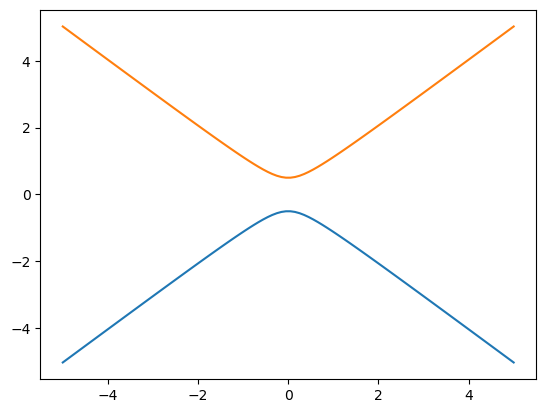

In [168]:
g = 50e-2
detuning_sweep = np.linspace(-5, 5, 100)
energies_list_tls = []
for detune in detuning_sweep:
    h = ham_tls(detune, g)
    h_npad = npad_rot(h, 0, 1)
    energies = Qobj(h_npad).diag()
    energies_list_tls.append(energies)
energies_mat_tls = np.array(energies_list_tls).T

plt.plot(detuning_sweep, energies_mat_tls[0])
plt.plot(detuning_sweep, energies_mat_tls[1])

plt.plot()

In [169]:
g = 50e-3
# g=0.
freq_q = 4.5
anharm_q = -130e-3
anharm_c = -60e-3
freq_c_sweep = np.linspace(5.0, 4.0, 100)

In [170]:
freq_c_sweep

array([5.        , 4.98989899, 4.97979798, 4.96969697, 4.95959596,
       4.94949495, 4.93939394, 4.92929293, 4.91919192, 4.90909091,
       4.8989899 , 4.88888889, 4.87878788, 4.86868687, 4.85858586,
       4.84848485, 4.83838384, 4.82828283, 4.81818182, 4.80808081,
       4.7979798 , 4.78787879, 4.77777778, 4.76767677, 4.75757576,
       4.74747475, 4.73737374, 4.72727273, 4.71717172, 4.70707071,
       4.6969697 , 4.68686869, 4.67676768, 4.66666667, 4.65656566,
       4.64646465, 4.63636364, 4.62626263, 4.61616162, 4.60606061,
       4.5959596 , 4.58585859, 4.57575758, 4.56565657, 4.55555556,
       4.54545455, 4.53535354, 4.52525253, 4.51515152, 4.50505051,
       4.49494949, 4.48484848, 4.47474747, 4.46464646, 4.45454545,
       4.44444444, 4.43434343, 4.42424242, 4.41414141, 4.4040404 ,
       4.39393939, 4.38383838, 4.37373737, 4.36363636, 4.35353535,
       4.34343434, 4.33333333, 4.32323232, 4.31313131, 4.3030303 ,
       4.29292929, 4.28282828, 4.27272727, 4.26262626, 4.25252

In [171]:
energies_list = []
for freq_c in freq_c_sweep:
    h = ham_3ls(freq_q, freq_c, g, anharm_q, anharm_c)
    h = Qobj(h)
    energies = h.eigenenergies()
    energies_list.append(energies)
energies_mat = np.array(energies_list).T

[]

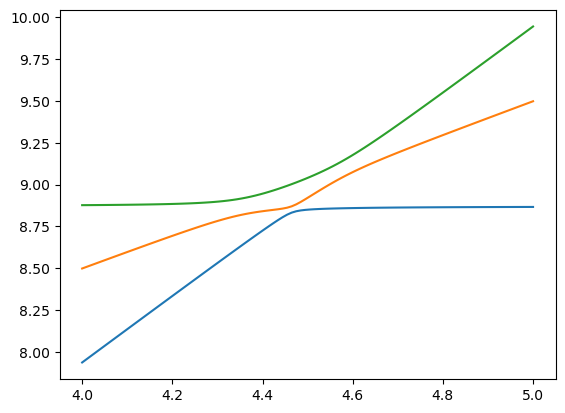

In [172]:
plt.plot(freq_c_sweep, energies_mat[0])
plt.plot(freq_c_sweep, energies_mat[1])
plt.plot(freq_c_sweep, energies_mat[2])

plt.plot()

In [173]:
print(2 * freq_q + anharm_q)
print(freq_q + freq_c)
print(2 * freq_c_sweep[0] + anharm_c)


8.87
8.5
9.94


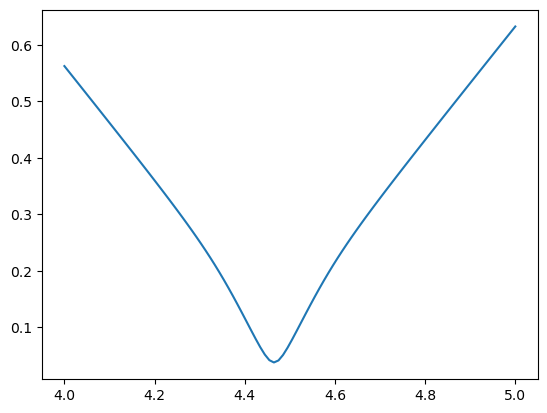

In [174]:
diff = energies_mat[1] - energies_mat[0]
plt.plot(freq_c_sweep, diff)
plt.show()

In [175]:
h1_list = [ham_3ls(freq_q, freq_c, g, anharm_q, anharm_c) for freq_c in freq_c_sweep]
h1_diag = np.array([np.diag(_h) for _h in h1_list]).T

In [176]:
# plt.plot(freq_c_sweep, h1_diag[0])
# plt.plot(freq_c_sweep, h1_diag[1])
# plt.plot(freq_c_sweep, h1_diag[2])

# plt.show()

In [177]:
# 0, 1 
h2_list = []
for h1 in h1_list:
    h2_list.append(npad_rot(h1, 0, 1))

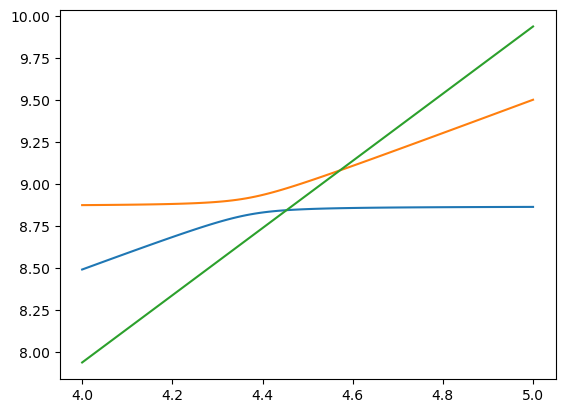

In [178]:
h2_diag = np.array([Qobj(h).diag() for h in h2_list]).T
plt.plot(freq_c_sweep, h2_diag[0])
plt.plot(freq_c_sweep, h2_diag[1])
plt.plot(freq_c_sweep, h2_diag[2])

plt.show()

In [179]:
# 0, 2
h3_list = []
for h2 in h2_list:
    h3_list.append(npad_rot(h2, 0, 2))

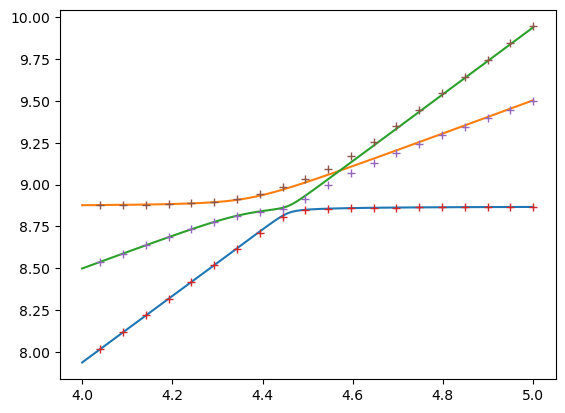

In [180]:
h3_diag = np.array([Qobj(h).diag() for h in h3_list]).T
plt.plot(freq_c_sweep, h3_diag[0])
plt.plot(freq_c_sweep, h3_diag[1])
plt.plot(freq_c_sweep, h3_diag[2])
plt.plot(freq_c_sweep[::5], energies_mat[0][::5], '+')
plt.plot(freq_c_sweep[::5], energies_mat[1][::5], '+')
plt.plot(freq_c_sweep[::5], energies_mat[2][::5], '+')

plt.show()

In [181]:
# 1, 2
h4_list = []
for h3 in h3_list:
    h4_list.append(npad_rot(h3, 1, 2))

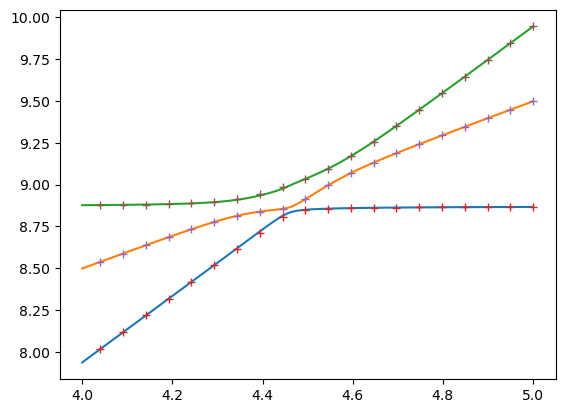

In [182]:
h4_diag = np.array([Qobj(h).diag() for h in h4_list]).T
plt.plot(freq_c_sweep, h4_diag[0])
plt.plot(freq_c_sweep, h4_diag[1])
plt.plot(freq_c_sweep, h4_diag[2])

plt.plot(freq_c_sweep[::5], energies_mat[0][::5], '+')
plt.plot(freq_c_sweep[::5], energies_mat[1][::5], '+')
plt.plot(freq_c_sweep[::5], energies_mat[2][::5], '+')


plt.show()

In [183]:
h4_list[70]

array([[ 8.51782292e+00+0.j, -7.13632375e-04+0.j,  2.17094514e-02+0.j],
       [-7.13632375e-04+0.j,  8.77624579e+00+0.j,  4.44089210e-16+0.j],
       [ 2.17094514e-02+0.j,  0.00000000e+00+0.j,  8.89471917e+00+0.j]])

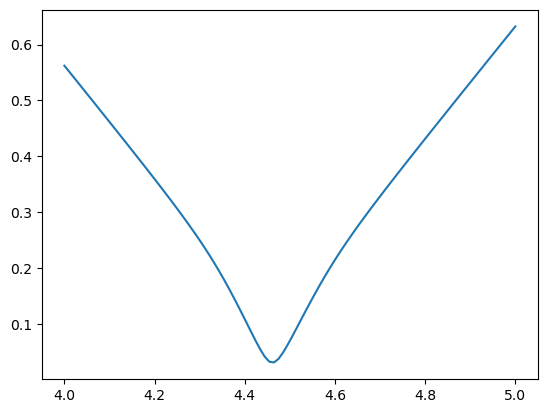

In [184]:
plt.plot(freq_c_sweep, h4_diag[1] - h4_diag[0])
plt.show()


# Symbolic RSWT 

In [185]:
def generator_element(h, j, k):
    D = sp.diag(h)
    V_jk = h[j, k]
    D_j, D_k = D[j, j], D[k, k]
    S_jk = V_jk / (D_j - D_k)
    return S_jk

def commutator(A, B):
    return A * B - B * A

def commutator_ct(A, ct_last):
    Ct = commutator(A, ct_last)
    return Ct 

def generator(V, D):
    S = sp.zeros(sp.shape(V)[0], sp.shape(V)[1])
    for j in range(V.rows):
        for k in range(V.cols):
            if V[j, k] != 0:
                s_jk = V[j, k] / (D[j, j] - D[k, k])
                S[j, k] = s_jk
    return S

def update_h(m, S, D, V):
    h = D
    Ct = commutator(S, V)
    for t in range(1, m):
        h = h + (t / sp.factorial(t+1)) * Ct
        Ct = commutator_ct(S, Ct)
    return h

def RSWT(h0, K):
    n_max = floor(np.log2(K))
    hn = h0
    h_list = [h0]
    for n in range(n_max):
        Dn = sp.diag(*hn.diagonal())
        Vn = hn - Dn
        Sn = generator(Vn, Dn)
        m = floor(K / (2 ** n))
        hn = update_h(m, Sn, Dn, Vn)
        h_list.append(hn)
    return hn, h_list   

In [113]:
delta = sp.Symbol('Δ', real=True, positive=True, dtype=float)
g = sp.Symbol('g', positive=True, real=True, dtype=float)


h0_tls = sp.Matrix([
[delta,      g],
[g,       -delta]
])

In [114]:
K = 4


In [115]:
h, h_list = RSWT(h0_tls, K)
h

Matrix([
[-g**6/(18*Δ**4*(g**4/(4*Δ**3) - g**2/Δ - 2*Δ)) + g**6/(18*Δ**4*(-g**4/(4*Δ**3) + g**2/Δ + 2*Δ)) - g**4/(8*Δ**3) + g**2/(2*Δ) + Δ,                                                                                                                               0],
[                                                                                                                               0, g**6/(18*Δ**4*(g**4/(4*Δ**3) - g**2/Δ - 2*Δ)) - g**6/(18*Δ**4*(-g**4/(4*Δ**3) + g**2/Δ + 2*Δ)) + g**4/(8*Δ**3) - g**2/(2*Δ) - Δ]])

In [116]:
diff_tls =  h[0, 0] - h[1, 1]

In [117]:
diff_tls_expr =  h[0, 0] - h[1, 1]


In [118]:
delta_sweep = np.linspace(-10, 10, 100)
diff_tls_num = [diff_tls for d in delta_sweep]

## SWT

In [186]:
# symbolic 

delta1 = sp.Symbol('Δ', real=True)
del1 = sp.Symbol('δ', real=True)
g = sp.Symbol('g', real=True)

In [187]:
h_swt_tls = sp.Matrix([
[delta1 + g**2 * (delta1 / ((delta1 + del1) * (delta1-del1))), g ** 2 * del1 / (delta1**2-del1**2)],
[g ** 2 * del1 / (delta1**2-del1**2), - delta1 - g**2 * (delta1 / ((delta1 + del1) * (delta1-del1)))]])

h_swt_tls_approx = sp.Matrix([
[(1 - g ** 2 / del1 ** 2) * delta1, -g**2/del1],
[-g**2/del1, (-1 + g ** 2 / del1 ** 2) * delta1]])

# h_swt_tls_approx = sp.Matrix([
# [delta1, -g**2/del1],
# [-g**2/del1, delta1]])

In [188]:
h_swt_tls

Matrix([
[g**2*Δ/((Δ - δ)*(Δ + δ)) + Δ,          g**2*δ/(Δ**2 - δ**2)],
[        g**2*δ/(Δ**2 - δ**2), -g**2*Δ/((Δ - δ)*(Δ + δ)) - Δ]])

In [189]:
h_swt_tls_approx

Matrix([
[Δ*(-g**2/δ**2 + 1),           -g**2/δ],
[           -g**2/δ, Δ*(g**2/δ**2 - 1)]])

In [190]:
E0 = sp.sqrt(h_swt_tls[0] ** 2 + h_swt_tls[1] ** 2)
E0_apprx = sp.sqrt(h_swt_tls_approx[0] ** 2 + h_swt_tls_approx[1] ** 2)

In [191]:
E0

sqrt(g**4*δ**2/(Δ**2 - δ**2)**2 + (g**2*Δ/((Δ - δ)*(Δ + δ)) + Δ)**2)

In [192]:
g_val = 50e-3
a_val = -256e-3
del_val = - a_val / 2
# delta_qc_sweep = np.linspace(-20 * g_val, 20 * g_val, 100)
delta_sweep = np.linspace(-1 * g_val, 1 * g_val, 200)

In [193]:
E0

sqrt(g**4*δ**2/(Δ**2 - δ**2)**2 + (g**2*Δ/((Δ - δ)*(Δ + δ)) + Δ)**2)

In [194]:
energies0_swt_tls = [E0.subs({g: g_val, delta1: d, del1: del_val}) for d in delta1_sweep]
energies1_swt_tls = [-E0.subs({g: g_val, delta1: d, del1: del_val}) for d in delta1_sweep]

energies0_swt_tls_approx = [E0_apprx.subs({g: g_val, delta1: d, del1: del_val}) for d in delta1_sweep]
energies1_swt_tls_approx = [-E0_apprx.subs({g: g_val, delta1: d, del1: del_val}) for d in delta1_sweep]

In [195]:
energies0_swt_tls[0]

0.0788289530433812

In [196]:
E0_apprx

sqrt(g**4/δ**2 + Δ**2*(-g**2/δ**2 + 1)**2)

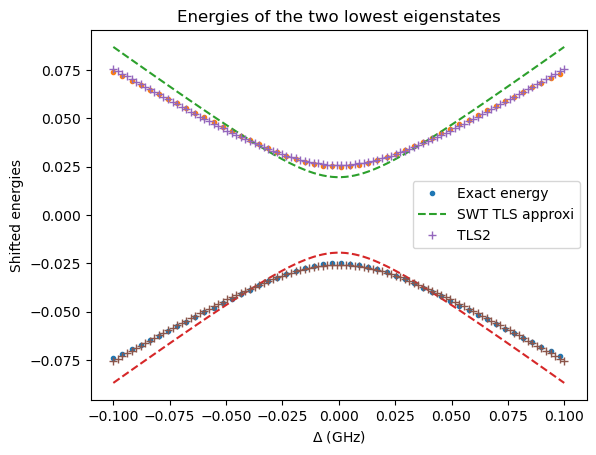

In [197]:
plt.plot(delta1_sweep[::eigen_step], eigen_val0[::eigen_step], '.', label='Exact energy')
plt.plot(delta1_sweep[::eigen_step], eigen_val1[::eigen_step], '.') 
# plt.plot(delta1_sweep, energies0_swt_tls, '-', label='SWT')
# plt.plot(delta1_sweep, energies1_swt_tls, '-', label='SWT')

plt.plot(delta1_sweep, energies0_swt_tls_approx, '--', label='SWT TLS approxi')
plt.plot(delta1_sweep, energies1_swt_tls_approx, '--')

plt.plot(delta1_sweep, fit_tls(delta1_sweep, g_tls2, scale_tls2), '+', label='TLS2')
plt.plot(delta1_sweep, -fit_tls(delta1_sweep, g_tls2, scale_tls2), '+')

plt.legend()

plt.xlabel(r'$\Delta$ (GHz)')
plt.ylabel('Shifted energies')
plt.title('Energies of the two lowest eigenstates')

plt.show()

# f reset using effective TLS

In [198]:
from qutip import sigmax, sigmaz, mesolve, basis, destroy, create, expect, tensor, qeye
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import warnings
from schedule import Schedule, run, ramp_array, find_eigen, generate_local_adiabatic_pulse
from scipy.optimize import curve_fit
warnings.filterwarnings("error")

In [199]:
fq = 5176.667e-3  # qubit 1 frequency

anharm_q = -100.7e-3  # anharmonicity 1
anharm_c = 0.e-3  # anharmonicity 2

g_val = 50e-3


# fc0 = 6552.000e-3  # coupler starting frequency
# fct = 4734.667e-3

fc0 = +2.5 * g_val + 0.5 * anharm_q + fq
fct = -2.5 * g_val + 0.5 * anharm_q + fq

# Levels
qubit_levels = 3
coupler_levels = 3

# Operators
a = tensor(destroy(qubit_levels), qeye(coupler_levels))
c = tensor(qeye(qubit_levels), destroy(coupler_levels))

# Uncoupled Hamiltonian
H0 = fq * 2 * pi * a.dag() * a + 0.5 * anharm_q * 2 * pi * a.dag() * a.dag() * a * a + fc0 * 2 * pi * c.dag() * c + 0.5 * anharm_c * 2 * pi * c.dag() * c.dag() * c * c 

# Interaction Hamiltonian
H1 = g_val * 2 * pi * (a.dag() * c + a * c.dag())

# Coupled Hamiltonian
H2 = H0 + H1

# Control term for tuning up the coupler frequency
Hd = 2 * pi * c.dag() * c

psi_q_0 = basis(qubit_levels, 0)
psi_q_1 = basis(qubit_levels, 1)
psi_q_2 = basis(qubit_levels, 2)

psi_c_0 = basis(coupler_levels, 0)
psi_c_1 = basis(coupler_levels, 1)
psi_c_2 = basis(coupler_levels, 2)

psi_init_00 = tensor(psi_q_0, psi_c_0)
psi_init_10 = tensor(psi_q_1, psi_c_0)
psi_init_01 = tensor(psi_q_0, psi_c_1)
psi_init_11 = tensor(psi_q_1, psi_c_1)
psi_init_02 = tensor(psi_q_0, psi_c_2)
psi_init_20 = tensor(psi_q_2, psi_c_0)

H2_eigen_energies = H2.eigenstates()[0]
H2_eigen_states = H2.eigenstates()[1]
psi_init_20_eigen, _, idx_20 = find_eigen(psi_init_20, H2_eigen_states, H2_eigen_energies)
psi_init_11_eigen, _, _ = find_eigen(psi_init_11, H2_eigen_states, H2_eigen_energies)
psi_init_02_eigen, _, _ = find_eigen(psi_init_02, H2_eigen_states, H2_eigen_energies)
psi_init_10_eigen, _, _ = find_eigen(psi_init_10, H2_eigen_states, H2_eigen_energies)

psi_init = psi_init_20_eigen
# psi_init = psi_init_20


In [200]:
h_swt_tls_approx


Matrix([
[Δ*(-g**2/δ**2 + 1),           -g**2/δ],
[           -g**2/δ, Δ*(g**2/δ**2 - 1)]])

$$
H_{\rm eff} = 
\begin{pmatrix}  

 (1 - 4g^2/\alpha^2)\Delta && 2g^2 / \alpha \\ 2g^2 / \alpha &&  -(1 - 4g^2/\alpha^2)\Delta

\end{pmatrix}
$$

$$
 g_{\rm eff} =  2g^2 / \alpha\\
$$

$$
\Delta_{eff} = 2(1 - 4 g^2 / \alpha^2)\Delta
$$

$$
\Delta = \omega_q - \omega_c + \alpha / 2
$$

$$
\Delta_{eff} = 2(1 - 4 g^2 / \alpha^2)(\Delta_{qc} + \alpha / 2)
$$

$$
\Delta_{qc} = \frac{1}{2(1 - 4g^2/\alpha^2)} \Delta_{eff} - \frac{\alpha}{2}
$$

# Effective TLS by fitting
$$
H_{\rm eff2} = \begin{pmatrix}  

 s \Delta && s g_{eff}  \\ 
 s g_{eff}  &&  -s\Delta

\end{pmatrix}
$$

In [201]:
def fit_tls_simple(x, g, scale):
    return scale * np.sqrt(x ** 2 +  g ** 2)

# def generate_local_adiabatic_pulse_tls2(g, T, y0, yt, dt, scale, g_eff):
    


In [202]:
# Effective tls

g2_val =  np.sqrt(2) * g_val

g_tls_eff = 2 * g2_val ** 2 / anharm_q

dt = 0.1

sched_tls = Schedule(sampling_rate=dt) 
sched_tls2 = Schedule(sampling_rate=dt) 

duration = 100

delta_qc0 = fq - fc0
delta_qct = fq - fct

delta_eff0 = 2 * (1 - 4 * g2_val ** 2 / anharm_q ** 2) * (delta_qc0 + 0.5 * anharm_q)
delta_efft = 2 * (1 - 4 * g2_val ** 2 / anharm_q ** 2) * (delta_qct + 0.5 * anharm_q)

delta_eff0_sim = 2 * (delta_qc0 + 0.5 * anharm_q)
delta_efft_sim = 2 * (delta_qct + 0.5 * anharm_q)

# delta_eff0_input = delta_eff0_sim
# delta_efft_input = delta_efft_sim

delta_eff0_input = delta_eff0
delta_efft_input = delta_efft


delta_tls_eff = generate_local_adiabatic_pulse(g=abs(1.0 * g_tls_eff), T=duration, y0=delta_eff0_input, yt=delta_efft_input, dt=dt)
delta_qc = (0.5 / (1 - 4 * g2_val ** 2 / anharm_q ** 2)) * delta_tls_eff - 0.5 * anharm_q


# scale_tls2 = 1.0

delta_tls2_eff0 = 1 * scale_tls2 * (delta_qc0 + 0.5 * anharm_q)
delta_tls2_efft = 1 * scale_tls2 * (delta_qct + 0.5 * anharm_q)

sta_scale = 1.0
delta_tls2_eff = generate_local_adiabatic_pulse(g=abs(sta_scale * scale_tls2 * g_tls2), T=duration, y0=delta_tls2_eff0, yt=delta_tls2_efft, dt=dt)
delta_qc2 = (1.0 * delta_tls2_eff / (scale_tls2)) - 0.5 * anharm_q


# delta_tls2_eff = generate_local_adiabatic_pulse(g=0.8 * g2_val, T=duration, y0=delta_qc0 + 0.5 * anharm_q, yt=delta_qct + 0.5 * anharm_q, dt=dt)
# delta_qc2 = delta_tls2_eff - 0.5 * anharm_q





pulse_arr_ct_c0_tls = - delta_qc + fq - fc0
pulse_arr_ct_c0_tls2 = - delta_qc2 + fq - fc0

time = np.linspace(0, duration, len(pulse_arr_ct_c0_tls))



In [2]:
print(delta_eff0)
print(delta_efft)

print(delta_eff0_sim)
print(delta_efft_sim)



NameError: name 'delta_eff0' is not defined

In [1]:
# plt.plot(time, pulse_arr_ct_c0_tls, label=r'SWT effective TLS')
plt.plot(time, pulse_arr_ct_c0_tls2, label=r'fitting TLS2')


plt.grid(linestyle = '--', linewidth = 1.0)

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('ct-c0 Detuning (GHz)')
plt.title('Flux Ct-C0 detuning')
plt.show()

NameError: name 'plt' is not defined

In [205]:
sched_tls.append_list(list(pulse_arr_ct_c0_tls))
# sched_tls.plot()

sched_tls2.append_list(list(pulse_arr_ct_c0_tls2))
# sched_tls2.plot()

In [206]:
H_tls = [H2, [Hd, sched_tls.sequence[::1]]]
expt_op_adia = [psi_init_10_eigen * psi_init_10_eigen.dag(), psi_init_20_eigen * psi_init_20_eigen.dag(), psi_init_11_eigen * psi_init_11_eigen.dag(), psi_init_02_eigen * psi_init_02_eigen.dag()]
times_tls = np.linspace(0, sched_tls.time, len(sched_tls.sequence))

exp_vals, overlap = run(H0=H_tls[0], Ht=H_tls[1], times=times_tls, psi_init=psi_init, e_ops=expt_op_adia, eigen_idx=[3, 4, 5])

(3, 1000)


In [207]:
H_tls2 = [H2, [Hd, sched_tls2.sequence[::1]]]
expt_op_adia = [psi_init_10_eigen * psi_init_10_eigen.dag(), psi_init_20_eigen * psi_init_20_eigen.dag(), psi_init_11_eigen * psi_init_11_eigen.dag(), psi_init_02_eigen * psi_init_02_eigen.dag()]
times_tls2 = np.linspace(0, sched_tls2.time, len(sched_tls2.sequence))

exp_vals2, overlap2 = run(H0=H_tls2[0], Ht=H_tls2[1], times=times_tls2, psi_init=psi_init, e_ops=expt_op_adia, eigen_idx=[3, 4, 5])

(3, 1000)


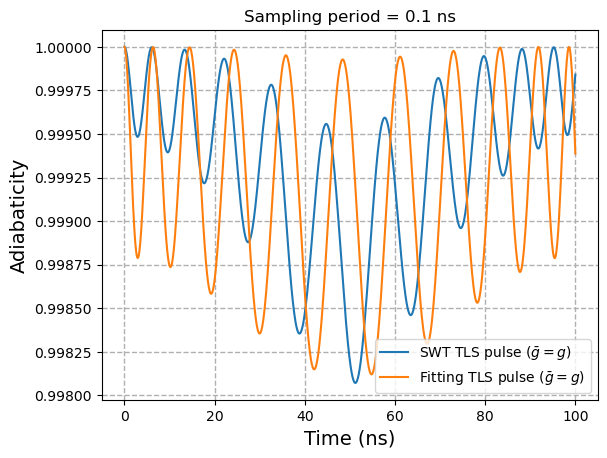

0.9998409672701103
0.9993879717720827


In [208]:
plt.plot(times_tls, overlap[0], label=r'SWT TLS pulse $(\bar{g}=g)$')
plt.plot(times_tls2, overlap2[0], label=r'Fitting TLS pulse $(\bar{g}=g)$')

plt.grid(linestyle = '--', linewidth = 1.0)

plt.legend()
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('Adiabaticity', fontsize=14)
plt.title(rf'Sampling period = {dt} ns')
plt.show()
print(overlap[0][-1])
print(overlap2[0][-1])


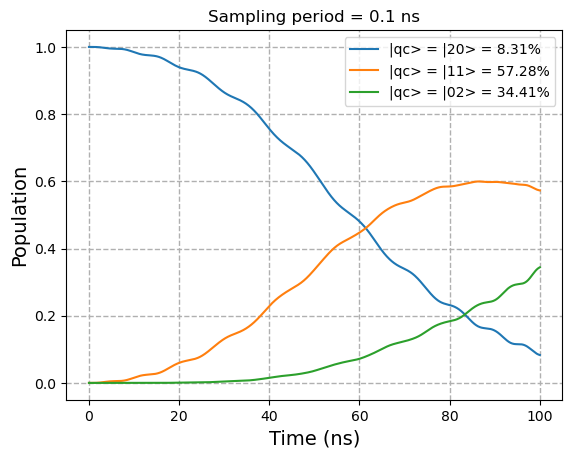

In [209]:
pop20, pop11, pop02 = exp_vals[1][-1], exp_vals[2][-1], exp_vals[3][-1]
plt.plot(times_tls, exp_vals[1], label=rf'|qc> = |20> = {np.round(pop20 * 100, 2)}% ')
plt.plot(times_tls, exp_vals[2], label=rf'|qc> = |11> = {np.round(pop11 * 100, 2)}%')
plt.plot(times_tls, exp_vals[3], label=rf'|qc> = |02> = {np.round(pop02 * 100, 2)}%')

plt.grid(linestyle = '--', linewidth = 1.0)

plt.legend()
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('Population', fontsize=14)

plt.title(rf'Sampling period = {dt} ns')

plt.show()

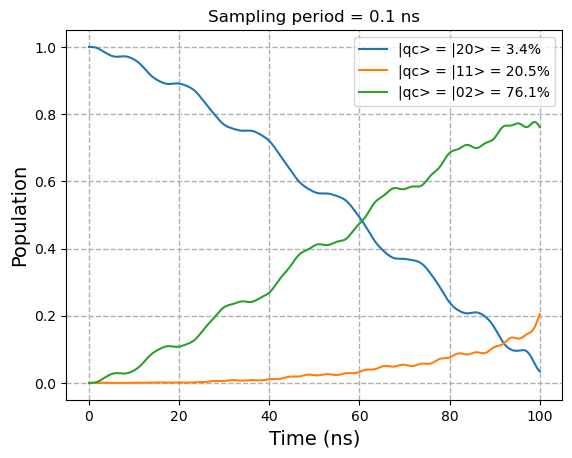

In [459]:
pop20, pop11, pop02 = exp_vals2[1][-1], exp_vals2[2][-1], exp_vals2[3][-1]
plt.plot(times_tls, exp_vals2[1], label=rf'|qc> = |20> = {np.round(pop20 * 100, 2)}% ')
plt.plot(times_tls, exp_vals2[2], label=rf'|qc> = |11> = {np.round(pop11 * 100, 2)}%')
plt.plot(times_tls, exp_vals2[3], label=rf'|qc> = |02> = {np.round(pop02 * 100, 2)}%')

plt.grid(linestyle = '--', linewidth = 1.0)

plt.legend()
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('Population', fontsize=14)

plt.title(rf'Sampling period = {dt} ns')

plt.show()